In [1]:
import pickle as pkl
import numpy as np

with open('stats.pkl', 'rb') as fp:
    data = pkl.load(fp)

In [2]:
rates = [[0] + [d[1]['I']/d[1]['E'] for d in dat] for dat in data]

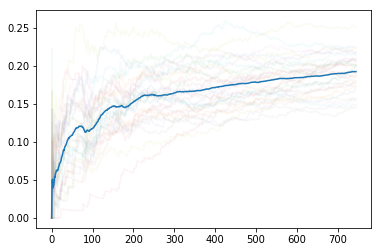

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

x = list(range(len(rates[0])))

for rate in rates:
    plt.plot(x, rate, alpha=0.05)
plt.plot(x, np.mean(np.transpose(rates), axis=1))
plt.show()

In [4]:
from scipy.optimize import curve_fit
import numpy as np

def f(x, a, b, c, d):
    return np.arctan((x+d)*a)*b+c

flatten = lambda l: [item for sublist in l for item in sublist]

# popt, pcov = curve_fit(f, x, np.mean(np.transpose(rates), axis=1), method='trf')
popt, pcov = curve_fit(f, x*len(rates), flatten(rates), method='trf')

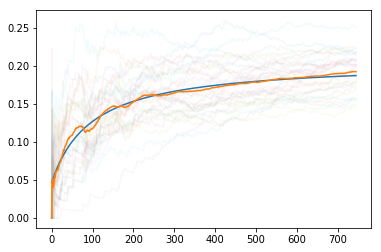

In [5]:
y = [f(xx, *popt) for xx in x]

plt.plot(x, y)
for rate in rates:
    plt.plot(x, rate, alpha=0.05)

plt.plot(x, np.mean(np.transpose(rates), axis=1))
plt.show()

In [6]:
infection_rate_scaler = 10.0 # Higher means more gradual reward increases as infection rate approaches 0.0
reward_scaler = 1000.0 # Scaling the magnitude of the reward (only impacts absolute magnitude of reward)
# infection_rate_chance = 0.18 # The 0 intercept of the reward, any worse than this is worse than chance performance
a, b, c, d = [2.95735301, 46.32006702, -72.55387083, 98.66898389]
xs = list(range(0, 744))
ys = np.linspace(-0.15, 0.15, 10)

x, y = np.meshgrid(xs, ys)

infection_rate_chance = np.arctan((x+d)*a)*b+c
infection_rate = infection_rate_chance + y
reward_offset = np.exp((1.0 - infection_rate_scaler)/(infection_rate_scaler*infection_rate_chance))
reward = reward_scaler*(np.exp((1.0/infection_rate/infection_rate_scaler) - (1.0/infection_rate_chance))-reward_offset)

reward[x <= 24] = 0
reward = np.clip(reward, -10, 10)

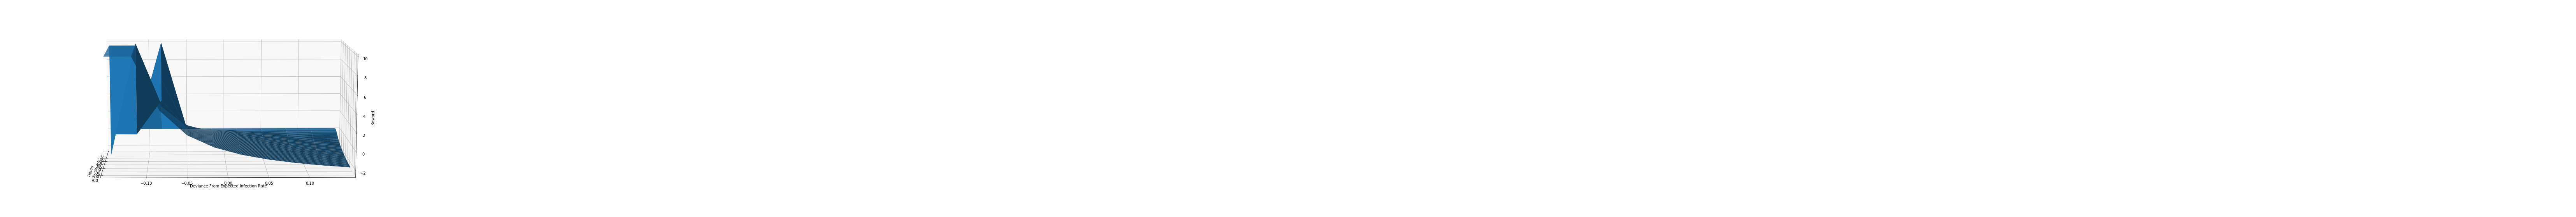

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, reward)

ax.set_xlabel('Hours')
ax.set_ylabel('Deviance From Expected Infection Rate')
ax.set_zlabel('Reward')

ax.set_xlim3d(min(xs), max(xs))
ax.set_ylim3d(min(ys), max(ys))
ax.set_zlim3d(np.array(reward).min(), np.array(reward).max())
for ii in range(0,360):
    ax.view_init(elev=10., azim=ii)
    plt.savefig("./reward_surface/movie%03d.png" % ii)

In [ ]:
!ffmpeg -r 24 -f image2 -s 1440x720 -i ./reward_surface/movie%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p test.mp4